# Versuch 2: Data Augmentation

## Thema

Auch in diesem Versuch ist das Ziel die Klassierfizierung in den Klassen befestigt und unbefestigt von Fahrradwegen. 
Als Regulierung der Überanpassung und besseren Generalisierung des Modells soll Data Augmentation verwendet werden. Wie die Generierung der zusätzlichen Daten umgesetzt wird siehe das Notebook unter bildverarbeitung/dataAugmentationExperiment.ipynb in dem gleichen Repository. Als Quellbilder werden die gleichen Bilder aus dem Versuch 1 genommen. 

## Hypothese

Mit der Vermehrung anhand von Data Augmentation der Trainingsdaten ist eine genauere Klassifizierung möglich als in Versuch 1. Unterstützt wird die These durch "The Effectiveness of Data Augmentation in Image Classification using Deep Learning”(https://arxiv.org/abs/1712.04621). In dem Artikel wird untersucht ob es möglich ist mit Data Augmentation einen kleinen Datensatz (wenige tausend Daten) mit Labeln zu nutzen anstelle eines Datensatz mit mehreren Hunderttausenden Bildern und keinen Labeln, um ein Faltungsnetz zu trainieren.  

## Versuchsaufbau
 
Wie in Versuch 1 beschrieben kommen die Daten aus den Datensatz 22. Dabei wird der gleiche Ausschnitt und Skalierung der Bilder verwendet. Auch in diesem Versuch soll für die Klassifizierung ein Faltungsnetzt trainiert werden siehe Tab. 2, um einen Überblick der verwendeten Paramater des Netz zu bekommen. Das Neuronale Netzt wird auf einem PC mit einer GTX 1060 trainiert.   
   
Klasse | Verwendeter Datensatz | Anzahl der Quellbilder | Anzahl der mit Data Augmentation erzeugten Bilder | Gesamtzahl der Bilder | Größe der Zielbilder(Skaliert)
--- | --- | --- | --- | --- |
 unbefestigt | 22 | 1000 | 400 | 1400 | 70px x 362px 
 befestigt | 22 | 1000 | 400 | 1400 | 70px x 362px
Tabelle 1: Beschreibung der Trainingsdaten

## Versuchsdurchführung

Zuerst werden die zusätzlichen Daten generiert (siehe Abb. 1) in dem Notebook dataAugmentationExperiment.ipynb. Dabei werden die augmentierten Daten nur aus den Trainingsdaten erzeugt. Die Trainingsdaten plus den generierten und Validierungsdaten werden anschließend geladen. Ein Faltungsnetz wird im nächsten Schritt trainiert mit den Parametern aus dem Versuch 1. Die Anzahl der Epochen sind 100 wobei Early Stopping gnutzt wird. Das jeweils beste gefundene Modell nach der Metrik Test accuracy wird abgespeichert in den Ordner ergebnisse_versuch2/.

![alt text][logo]
Abbildung 1: Beispiel Daten Augmentation mit mehreren Transformationen sowie 0.1 Grad Wertebereich: 

[logo]: ../daten/datensatz/22/abb/dataAugmentation0_1.jpg "Daten Augmentation mit mehreren Transformationen sowie 0.1 Grad Wertebereich"

### Versuch 2.1

Mit Data Augmentation werden zusätzlich 400 Trainingsdaten je Klasse erzeugt. Dabei werden mit den ImageDataGenerator transformationen in dem Wertebereich [-0.1,0.1] erzeugt(siehe dataAugmentationExperiment.ipyn).  

## Versuchsbeobachtung
 
Versuch Nr. | Training accuracy | Training loss | Validation accuracy | Validation loss | Gesamtanzahl der mit Data Augmentation erzeugten Bilder
--- | --- | --- | --- | --- | --|
1 |  | 800

## Auswertung

In [1]:
from __future__ import print_function
from hyperopt import Trials, STATUS_OK, rand
from hyperas import optim
from hyperas.distributions import uniform, choice

C:\Users\user\AppData\Local\conda\conda\envs\bicycle\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Import von Bibliotheken
import os
import cv2
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
import keras.callbacks as cb
import numpy as np
import pandas

In [3]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [4]:
# Um Grafiken zu plotten
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn

In [5]:
images            = []          # Liste für alle Bilder
imagesNp          = np.array(0) # soll Bilder als numpy Array halten
startIndexUnpaved = 0           # Index Beginn der befestigte Wege
numberOfChannels  = 3           # Anzahl der Farbkanäle
numberOfClasses   = 2           # Anzahl der Klassen
classNames        = ['unbefestigt','befestigt'] # Namen der Klassen
yLabels           = np.array(0) # Labels / Klassen zuordnung
yShuffle          = np.array(0) # Labels mit der Methode shuffle() vermischt 
xShuffle          = np.array(0) # Bilder zum trainieren mit shuffle() vermischt
xTrain            = np.array(0) # Trainingsdaten (Bilder) 
xTest             = np.array(0) # Testdaten (Bilder)
yTrain            = np.array(0) # Klassen zuordnungen (Labels) für xTrain
yTest             = np.array(0) # Klassen zuordnung (Lables) für xTest

In [6]:
# Läd alle Bildaufnahmen der Klasse unbefestigt 
imagePathName = 'C:/Users/morro/Documents/fahrradwegeKlassifizierung/daten/datensatz/22/unbefestigt/zugeschnitten/'
files = os.listdir(imagePathName)
for file in files:
    if "jpg" not in file:
        continue
    images.append(cv2.cvtColor(cv2.imread(imagePathName + file),cv2.COLOR_BGR2RGB))

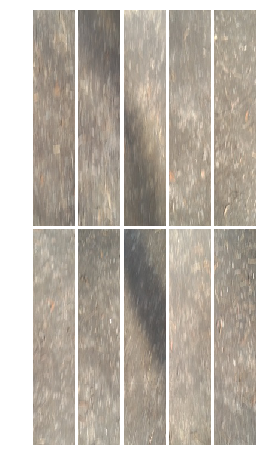

In [7]:
# Einige Beispiele von unbefestigten Wegen
fig = plt.figure(1,figsize=(8,8))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 5), axes_pad=0.05)
imageToShow = 10
for i, img in enumerate(images[0: imageToShow]):
    ax = grid[i]
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [8]:
# Läd alle Bildaufnahmen der Klasse befestigt
startIndexpaved = len(images)
imagePathName = 'C:/Users/morro/Documents/fahrradwegeKlassifizierung/daten/datensatz/22/befestigt/zugeschnitten/'
files = os.listdir(imagePathName)
for file in files:
    if "jpg" not in file:
        continue
    images.append(cv2.cvtColor(cv2.imread(imagePathName + file),cv2.COLOR_BGR2RGB))

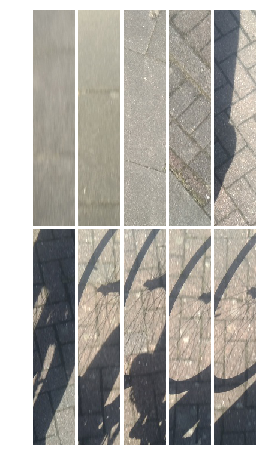

In [9]:
# Einige Beispiele von befestigten Wegen
fig = plt.figure(1,figsize=(8,8))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 5), axes_pad=0.05)
imageToShow = 10
for i, img in enumerate(images[startIndexpaved: startIndexpaved + imageToShow]):
    ax = grid[i]
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [10]:
# Y Klassen Labels zuweisen
# 0 unbefestigt
# 1 befestigt
yLabels = np.zeros(len(images)) 
yLabels[startIndexpaved:len(images)] = 1

In [11]:
# Erstellt einen "one hot encoding vector" für die gelabelten Bilder
yLabels = np_utils.to_categorical(yLabels, 0)

In [12]:
len(images)

2000

In [13]:
yLabels[998]

array([1., 0.])

In [14]:
# Setzten des RandomState um reproduzierbare Ergebnisse zu erzielen.
np.random.seed(42)

In [15]:
imagesNp = np.array(images)
imagesNp = imagesNp.astype('float32')
# Transfomierung der Bildpunkte auf den Wetebereich von 0 bis 1
imagesNp /= 255
print (imagesNp.shape) # Form des Arrays (Anzahl der Bilder, Höhe, Breite, Farbkanäle)

(2000, 362, 70, 3)


In [16]:
# Mischen der Trainingsdaten
xShuffle, yShuffle = shuffle(imagesNp,yLabels)
# Aufteilung in Trainings und Testdaten
xTrain, xTest, yTrain, yTest = train_test_split(xShuffle, yShuffle, test_size=0.2)

In [17]:
yTrain.shape[0]

1600

In [18]:
# yTrain Labels von den augmentierten Bildern hinzufügen
# Schritt 1: zweidimensionales Array der Größe yTrain.shape[0] + Anzahl der augmentierten Bilder erstellen
# 2: Array Werte aus yTrain dem Array zuweisen
# 3: Label aus den generierten Daten zuweisen
# 4: erstelltes Array yTrain zuweisen
numberOfAugmentedData = 800
yTrainTemp = np.zeros((yTrain.shape[0]+numberOfAugmentedData,yTrain.shape[1]))
yTrainTemp[0:yTrain.shape[0]] = yTrain
yTrainTemp[yTrain.shape[0]:(yTrain.shape[0]+(int(numberOfAugmentedData/2)))] = [1.,0.] # unbefestigt
yTrainTemp[(yTrain.shape[0]+(int(numberOfAugmentedData/2))):(yTrain.shape[0]+numberOfAugmentedData)] = [0.,1.] # befestigt
yTrain = yTrainTemp

In [19]:
yTrain[2333]

array([0., 1.])

In [20]:
# Bilder der Klasse unbefestigt erzeugt mit Data Augmentation laden
unpavedImages = []
imagePathName = 'C:/Users/morro/Documents/fahrradwegeKlassifizierung/daten/datensatz/22/unbefestigt/augmentation/'
files = os.listdir(imagePathName)
for file in files:
    if "jpg" not in file:
        continue
    unpavedImages.append(cv2.cvtColor(cv2.imread(imagePathName + file),cv2.COLOR_BGR2RGB))

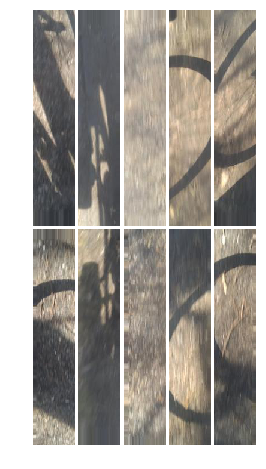

In [21]:
# Einige Beispiele von befestigten Wegen
fig = plt.figure(1,figsize=(8,8))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 5), axes_pad=0.05)
imageToShow = 10
for i, img in enumerate(unpavedImages[0:imageToShow]):
    ax = grid[i]
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [22]:
# unpaved List in Array umwandeln
unpavedImagesNp = np.array(unpavedImages)
unpavedImagesNp = unpavedImagesNp.astype('float32')
# Transfomierung der Bildpunkte auf den Wetebereich von 0 bis 1
unpavedImagesNp /= 255
print (unpavedImagesNp.shape) # Form des Arrays (Anzahl der Bilder, Höhe, Breite, Farbkanäle)

(400, 362, 70, 3)


In [23]:
# Bilder der Klasse befestigt erzeugt mit Data Augmentation laden
pavedImages = []
imagePathName = 'C:/Users/morro/Documents/fahrradwegeKlassifizierung/daten/datensatz/22/befestigt/augmentation/'
files = os.listdir(imagePathName)
for file in files:
    if "jpg" not in file:
        continue
    pavedImages.append(cv2.cvtColor(cv2.imread(imagePathName + file),cv2.COLOR_BGR2RGB))

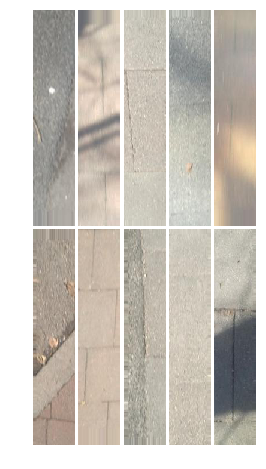

In [24]:
# Einige Beispiele von befestigten Wegen
fig = plt.figure(1,figsize=(8,8))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 5), axes_pad=0.05)
imageToShow = 10
for i, img in enumerate(pavedImages[0:imageToShow]):
    ax = grid[i]
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [25]:
# unpaved List in Array umwandeln
pavedImagesNp = np.array(pavedImages)
pavedImagesNp = pavedImagesNp.astype('float32')
# Transfomierung der Bildpunkte auf den Wetebereich von 0 bis 1
pavedImagesNp /= 255
print (pavedImagesNp.shape) # Form des Arrays (Anzahl der Bilder, Höhe, Breite, Farbkanäle)

(400, 362, 70, 3)


In [26]:
xTrain.shape

(1600, 362, 70, 3)

In [27]:
# xTrain um generierte Bilder erweitern
xTrainTemp = np.zeros((xTrain.shape[0]+numberOfAugmentedData,xTrain.shape[1],xTrain.shape[2],xTrain.shape[3]))
xTrainTemp[0:xTrain.shape[0]] = xTrain
xTrainTemp[xTrain.shape[0]:(xTrain.shape[0]+(int(numberOfAugmentedData/2)))] = unpavedImagesNp # unbefestigt
xTrainTemp[(xTrain.shape[0]+(int(numberOfAugmentedData/2))):(xTrain.shape[0]+numberOfAugmentedData)] = pavedImagesNp # befestigt
xTrain = xTrainTemp

In [28]:
yTrain[2002]

array([0., 1.])

In [29]:
len(xTrain) # Anzahl der Trainingsdaten

2400

In [30]:
len(yTest) # Anzahl der Testdaten

400

<b> Initialisierung des Faltungsnetz </b>
*****

In [31]:
# Parameter für das CNN
inputShape     = imagesNp[0].shape # Eingangs Array-Form 
numNeuronsC1   = 32                # Anzahl der Filter / 1 Faltungsschicht
numNeuronsC2   = 32                # Anzahl der Filter / 2 Faltungsschicht
numNeuronsC3   = 64                # Anzahl der Filter / 3 Faltungsschicht
numNeuronsD1   = 64                # Anzahl der Neuronen des Fully connected layer - vollverbundene Schicht
poolSize       = 2                 # Größe der Pooling-Layer
convKernelSize = 3                 # Größe des Faltungskern n*n

In [32]:
model = Sequential()
model.add(Conv2D(numNeuronsC1, (convKernelSize, convKernelSize), padding='valid',input_shape=inputShape))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(poolSize, poolSize)))
model.add(Dropout(0.05))

model.add(Conv2D(numNeuronsC2, (convKernelSize, convKernelSize)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(poolSize, poolSize)))
model.add(Dropout(0.33))
  
model.add(Conv2D(numNeuronsC3, (convKernelSize, convKernelSize)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(poolSize, poolSize)))
model.add(Dropout(0.10))

model.add(Flatten())
model.add(Dense(numNeuronsD1))
model.add(Activation('elu'))
model.add(Dropout(0.46))

model.add(Dense(2))
model.add(Activation('softmax')) 

In [33]:
# Zusammenfassung der Parameter des neuralen Netzes
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 360, 68, 32)       896       
_________________________________________________________________
activation_1 (Activation)    (None, 360, 68, 32)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 180, 34, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 180, 34, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 178, 32, 32)       9248      
_________________________________________________________________
activation_2 (Activation)    (None, 178, 32, 32)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 89, 16, 32)        0         
__________

<b> Trainieren des Faltungsnetz</b>
*****

In [34]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=["accuracy"])

In [46]:
numEpoch=100
# Early Stopping unterbricht das Training, wenn nach n Epochen die Kostenfunktion nicht weiter minimiert werden konnte 
earlyStopping = cb.EarlyStopping(monitor='val_acc', patience=10, verbose=0, mode='max')   
# Speichert das beste Modell mit der höhsten Test Accuracy ab
checkpointSafe = cb.ModelCheckpoint('ergebnisse_versuch2/versuch2_1', monitor='val_acc', save_best_only=True)
hist = model.fit(xTrain, yTrain, batch_size=32, epochs=numEpoch,
              validation_data=(xTest, yTest), callbacks=[earlyStopping,checkpointSafe])

Train on 2400 samples, validate on 400 samples
Epoch 1/100
2400/2400 [==============================] - 5s 2ms/step - loss: 0.0581 - acc: 0.9842 - val_loss: 0.3156 - val_acc: 0.9275
Epoch 2/100
2400/2400 [==============================] - 5s 2ms/step - loss: 0.0581 - acc: 0.9771 - val_loss: 0.3211 - val_acc: 0.9300
Epoch 3/100
2400/2400 [==============================] - 5s 2ms/step - loss: 0.0637 - acc: 0.9788 - val_loss: 0.3453 - val_acc: 0.9225
Epoch 4/100
2400/2400 [==============================] - 5s 2ms/step - loss: 0.0331 - acc: 0.9887 - val_loss: 0.8604 - val_acc: 0.8525
Epoch 5/100
2400/2400 [==============================] - 5s 2ms/step - loss: 0.0349 - acc: 0.9871 - val_loss: 0.8066 - val_acc: 0.8475
Epoch 6/100
2400/2400 [==============================] - 5s 2ms/step - loss: 0.0234 - acc: 0.9917 - val_loss: 0.4481 - val_acc: 0.9250
Epoch 7/100
2400/2400 [==============================] - 5s 2ms/step - loss: 0.0406 - acc: 0.9875 - val_loss: 0.3891 - val_acc: 0.9275 acc
Epoc

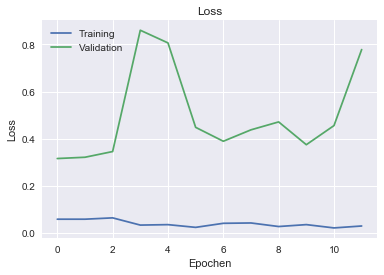

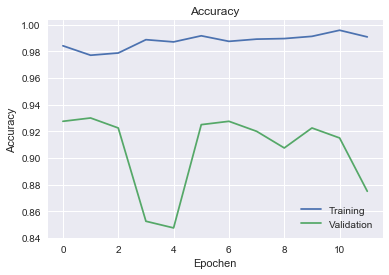

In [47]:
plt.figure(4)
plt.title('Loss')
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.grid(True)
plt.figure(1)
plt.title('Accuracy')
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.grid(True)
plt.show()

[[163  45]
 [  5 187]]


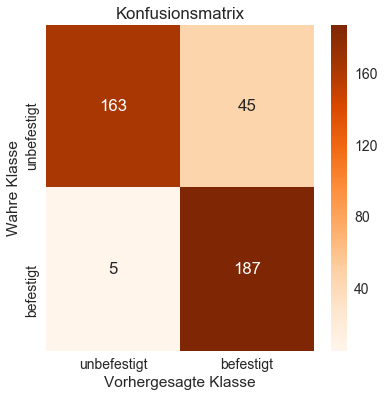

In [53]:
# Konfusionsmatrix
validPreds = model.predict(xTest)
validPreds = np.argmax(validPreds, axis=1)
yTestMax = np.argmax(yTest,axis=1)
cnfMatrix = confusion_matrix(yTestMax, validPreds)
print(cnfMatrix)
seaborn.set(font_scale=1.4)
fig, ax = plt.subplots(figsize=(6,6)) 
ax = seaborn.heatmap(cnfMatrix, fmt="d", cmap=plt.cm.Oranges, ax=ax , annot=True)
ax.set_xticklabels(classNames)
ax.set_yticklabels(classNames)
plt.title('Konfusionsmatrix')
plt.ylabel('Wahre Klasse')
plt.xlabel('Vorhergesagte Klasse')
plt.show()

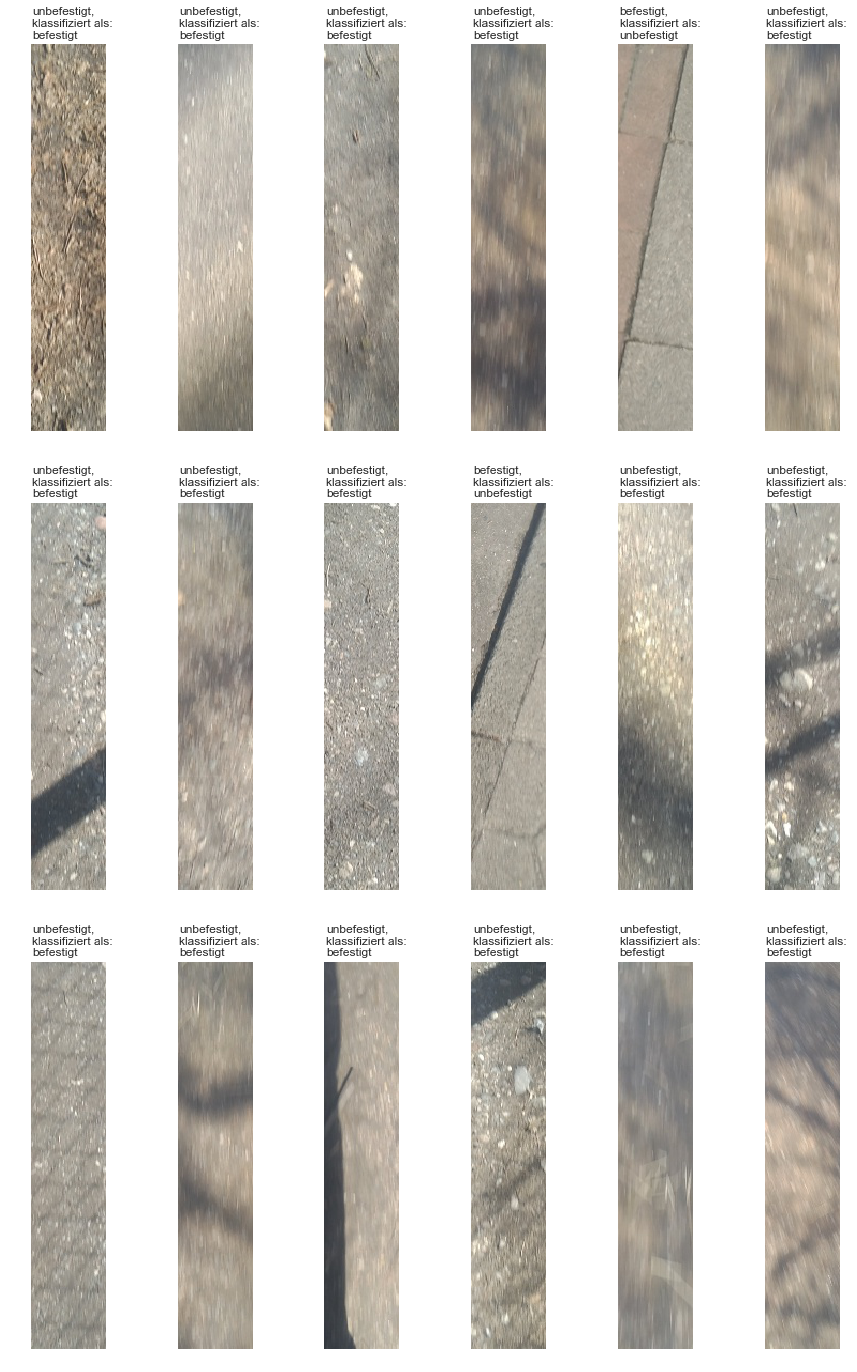

In [54]:
# Plot falsch vorhergesagte Bilder
predictedClasses = model.predict_classes(xTest)   
yTestNumber = np.argmax(yTest, axis=1)
incorrect = []
for i, y in enumerate(yTestNumber):
    if y != predictedClasses[i]:
        incorrect.append(i)
seaborn.set(font_scale=1)
fig = plt.figure(1, figsize=(24,24))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 6), axes_pad=1.0)
for i, incorr in enumerate(incorrect[0:18]):
    ax = grid[i]
    ax.imshow(xTest[incorr], cmap='gray')
    ax.text(1,-20, classNames[yTestNumber[incorr]] + ",\nklassifiziert als: \n" + classNames[predictedClasses[incorr]], verticalalignment='center')
    ax.axis('off')
plt.show() 

In [44]:
predictedClasses[10]

1

In [39]:
score = model.evaluate(xTest, yTest, verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

400/400 [==============================] - 0s 587us/step
Test Loss: 0.31536770820617677
Test accuracy: 0.92


In [41]:
classNames

['unbefestigt', 'befestigt']